# Titanic dataset analysis by using decision trees - scikit learn

In [1]:
import csv
import numpy as np
import pandas as pd

In [2]:
with open('Data/titanic.txt','rb') as csvfile:
    tit_reader = csv.reader(csvfile,delimiter=",",quotechar='"')
    
    # Extract header
    header = tit_reader.next()
    feature_names = np.array(header)
    
    # Load dataset and target classes
    tit_X, tit_y = [], []
    for record in tit_reader:
        tit_X.append(record)
        tit_y.append(record[2])
    
    tit_X = np.array(tit_X)
    tit_y = np.array(tit_y)

In [3]:
print feature_names

['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex']


In [4]:
print tit_X[0], tit_y[0]

['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 1


## Preprocess the data

In [5]:
# Feature selection
tit_X = tit_X[:,[1,4,10]] #class,age and sex
feature_names = feature_names[[1,4,10]]

In [6]:
print feature_names

['pclass' 'age' 'sex']


In [7]:
print tit_X[12],tit_y[12]

['1st' 'NA' 'female'] 1


Handle missing values

In [8]:
#Replace age with mean value
ages = tit_X[:,1]
mean_age = np.mean(tit_X[ages != 'NA',1].astype(np.float))
tit_X[ages == 'NA',1] = mean_age

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
enc = LabelEncoder()
label_encoder = enc.fit(tit_X[:,2])
print label_encoder.classes_

['female' 'male']


In [11]:
integer_classes = label_encoder.transform(label_encoder.classes_)
print integer_classes

[0 1]


In [12]:
# Transform sex to integer classes
tit_X[:,2] = label_encoder.transform(tit_X[:,2])

In [13]:
print feature_names
print tit_X[12], tit_y[12]

['pclass' 'age' 'sex']
['1st' '31.1941810427' '0'] 1


In [14]:
# Transform categorial classes into numerical values
from sklearn.preprocessing import OneHotEncoder

In [15]:
# Using label encoder
enc = LabelEncoder()
label_encoder = enc.fit(tit_X[:,0])
print "Categorial classes: " ,label_encoder.classes_
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3,1)
print "Integer classes: ", integer_classes

Categorial classes:  ['1st' '2nd' '3rd']
Integer classes:  [[0]
 [1]
 [2]]


In [16]:
# Using oneshot encoder
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)

We got the same output as LabelEncoder

In [17]:
nrows = tit_X.shape[0]
new_features = one_hot_encoder.transform(
    label_encoder.transform(tit_X[:,0]).reshape(nrows,1))

In [18]:
tit_X = np.concatenate([tit_X,new_features.toarray()],axis=1)

In [19]:
# Eliminate converted columns
tit_X = np.delete(tit_X,[0],1)

In [20]:
# Update feature names
feature_names = ['age','sex','first_class','second_class','third_class']

In [21]:
tit_X = tit_X.astype(float)
tit_Y = tit_y.astype(float)

In [22]:
print feature_names
print tit_X[12],tit_Y[12]

['age', 'sex', 'first_class', 'second_class', 'third_class']
[ 31.19418104   0.           1.           0.           0.        ] 1.0


## Training decision tree classifier

In [23]:
from sklearn.cross_validation import train_test_split

In [24]:
X_train,X_test,y_train,y_test = train_test_split(tit_X,tit_Y,
                                                 test_size = 0.25,
                                                 random_state=33)

In [25]:
from sklearn import tree

In [26]:
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=3,
                                  min_samples_leaf=5)

In [27]:
clf = clf.fit(X_train,y_train)

### Visualize decision tree

In [28]:
import pydotplus,StringIO

In [29]:
dot_data = StringIO.StringIO()

In [30]:
tree.export_graphviz(clf,out_file=dot_data,feature_names=feature_names)

In [31]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Images/titanic.png')

True

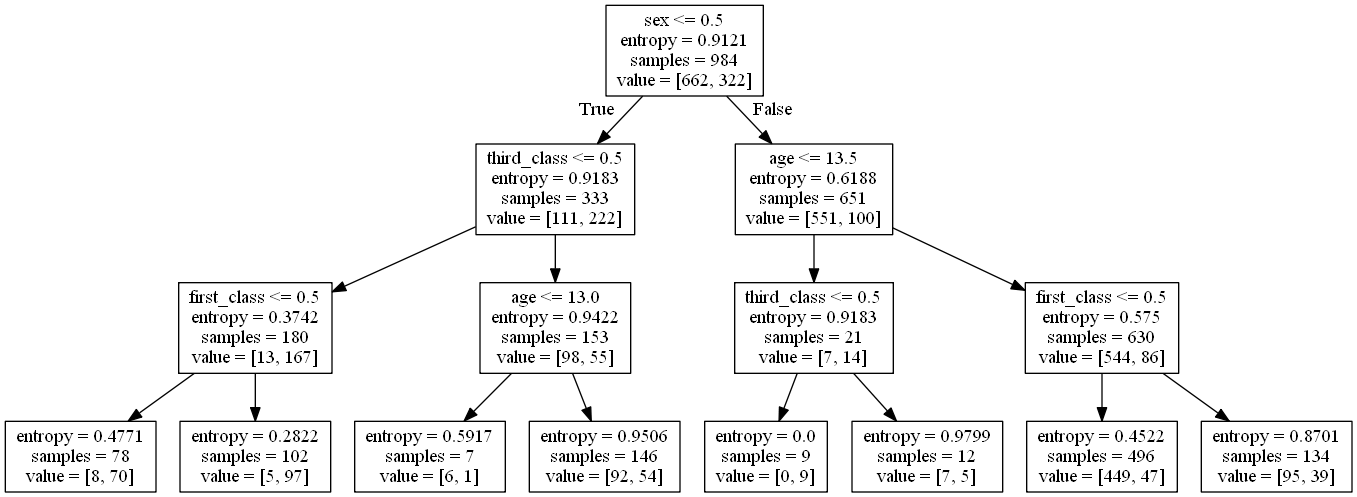

In [32]:
from IPython.core.display import Image
Image(filename='Images/titanic.png')

## Evaluating performance

In [33]:
from sklearn import metrics

In [34]:
def measure_performance(X,y,clf):
    predictions = clf.predict(X)
    print "Accuracy: {0:.3f}".format(metrics.accuracy_score(y,predictions))
    
    print "Classification report"
    print metrics.classification_report(y,predictions)
    
    print "Confusion metrix"
    print metrics.confusion_matrix(y,predictions)

In [35]:
measure_performance(X_test,y_test,clf)

Accuracy: 0.793
Classification report
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.85       202
        1.0       0.88      0.54      0.67       127

avg / total       0.81      0.79      0.78       329

Confusion metrix
[[193   9]
 [ 59  68]]


Decision trees are highly susceptible to overfitting so we will apply leave one out cross validation

### Apply cross-validation to prevent overfitting

In [36]:
from sklearn.cross_validation import cross_val_score,LeaveOneOut
from scipy.stats import sem

In [37]:
def loo_cv(X,y,clf):
    loo = LeaveOneOut(X[:].shape[0])
    scores = np.zeros(X[:].shape[0])
    for train_index,test_index in loo:
        X_train_cv, X_test_cv = X[train_index],X[test_index]
        y_train_cv, y_test_cv = y[train_index],y[test_index]
        
        clf = clf.fit(X_train_cv,y_train_cv)
        y_pred = clf.predict(X_test_cv)
        scores[test_index] = metrics.accuracy_score(y_test_cv,y_pred)
    print ("Mean score: {0:.3f}(+/-{1:.3f})").format(np.mean(scores),
                                                     sem(scores))

In [38]:
loo_cv(X_train,y_train,clf)

Mean score: 0.837(+/-0.012)
